# Notebook of comparison VAE and geometric VAE

In [21]:
import numpy as np
import pandas as pd
import scanpy as sc

from scCFM.models.base.vae import VAE
from scCFM.models.base.geometric_vae import GeometricNBVAE, GeometricNBAE
from scCFM.models.base.geodesic_ae import GeodesicAE

from scCFM.datamodules.sc_datamodule import scDataModule

from scCFM.models.manifold.geometry_metrics import compute_all_metrics

import sys
sys.path.insert(0, "../..")
from notebooks.utils import real_reconstructed_cells_adata

from paths import PROJECT_FOLDER
import torch
import anndata

import scipy

import seaborn as sns

import matplotlib.pyplot as plt

Initialize terminal states

In [22]:
terminal_states = [0, 1, 2, 3, 5] 
initial_states = [11, 12, 13]

**Util functions**

In [23]:
def make_joint_df(arrays, labels):
    """
    Stack arrays and associate the labels 
    """
    all_arrays = np.concatenate(arrays)
    all_labels = []
    for i,lab in enumerate(labels):
        all_labels += [lab for _ in range(len(arrays[i]))]
    return pd.DataFrame({"values": all_arrays,
                         "labels": all_labels})

## Initialize the two different configurations 

General module hparams

In [24]:
datamodule={'path': PROJECT_FOLDER / 'data/pancreas/processed/pancreas.h5ad', 
            'x_layer': 'X_norm', 
            'cond_keys': ['experimental_time', 'celltype'],
            'use_pca': False, 
            'n_dimensions': None, 
            'train_val_test_split': [1], 
            'batch_size': 128, 
            'num_workers': 2}


# Initialize datamodule
datamodule = scDataModule(**datamodule)

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


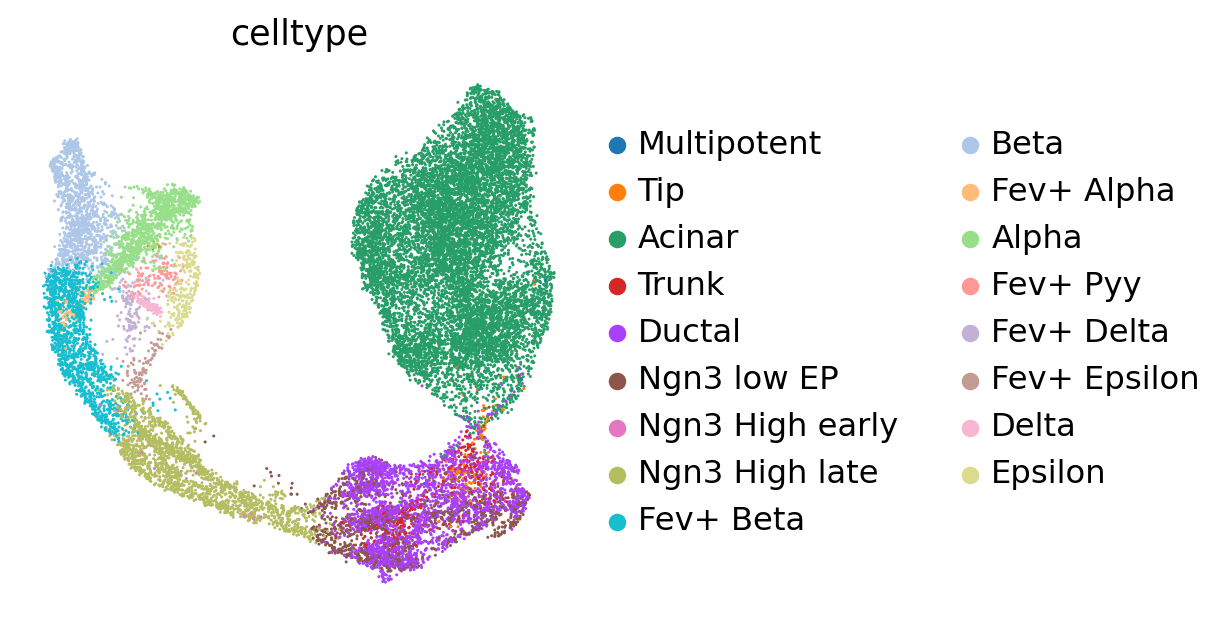

In [25]:
adata = sc.read_h5ad(PROJECT_FOLDER / 'data/pancreas/processed/pancreas.h5ad')
sc.pl.umap(adata, color="celltype")

### Model config VAE

In [26]:
model_vae={
       'in_dim': datamodule.in_dim,
       'n_epochs_anneal_kl': 1000, 
       'kl_weight': None, 
       'likelihood': 'nb', 
       'dropout': False, 
       'learning_rate': 0.001, 
       'dropout_p': False, 
       'model_library_size': True, 
       'batch_norm': True, 
       'kl_warmup_fraction': 0.1, 
       'hidden_dims': [256, 20]}
        
geometric={'compute_metrics_every': 1, 
           'use_c': True, 
           "trainable_c": False,
           'l2': True, 
           'eta_interp': 0, 
           'interpolate_z': False, 
           'start_jac_after' : 0, 
           'fl_weight': 0.1,
           'detach_theta': True}

geodesic={"in_dim": datamodule.in_dim,
          "hidden_dims": [256, 10],
          "batch_norm": True,
          "dropout": False, 
          "dropout_p": False,
          "likelihood": "nb",
          "learning_rate": 0.001}

In [27]:
vae = GeometricNBVAE(**geometric, vae_kwargs=model_vae).eval()
geometric_vae = GeometricNBVAE(**geometric, vae_kwargs=model_vae).eval()
geodesic_ae = GeodesicAE(**geodesic)

In [28]:
vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/pancreas/best_model_vae_lib_20.ckpt")["state_dict"])
geometric_vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/pancreas/best_model_geometric_lib_20.ckpt")["state_dict"])
geodesic_ae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/pancreas/best_model_geodesic_ae_20.ckpt")["state_dict"])

<All keys matched successfully>

### Compute UMAPs

In [29]:
adata_vae_amortized_real, adata_vae_z, adata_vae_mu = real_reconstructed_cells_adata(vae, datamodule, process_amortized_adata=True, log1p=False, vae=True).values()
adata_geometric_amortized_real, adata_geometric_z, adata_geometric_mu = real_reconstructed_cells_adata(geometric_vae, datamodule, process_amortized_adata=True, log1p=False, vae=True).values()
adata_geodesic_amortized_real, adata_geodesic_z, adata_geodesic_mu = real_reconstructed_cells_adata(geodesic_ae, datamodule, process_amortized_adata=True, log1p=False, vae=False, model_type="geodesic").values()

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/icb/alessandro.palma/miniconda3/envs/s

In [30]:
adata_vae_z.obs["celltype"] = adata_vae_z.obs["celltype"].astype("category")
adata_geometric_z.obs["celltype"] = adata_geometric_z.obs["celltype"].astype("category")
adata_geodesic_z.obs["celltype"] = adata_geodesic_z.obs["celltype"].astype("category")

Plot the UMAP results

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


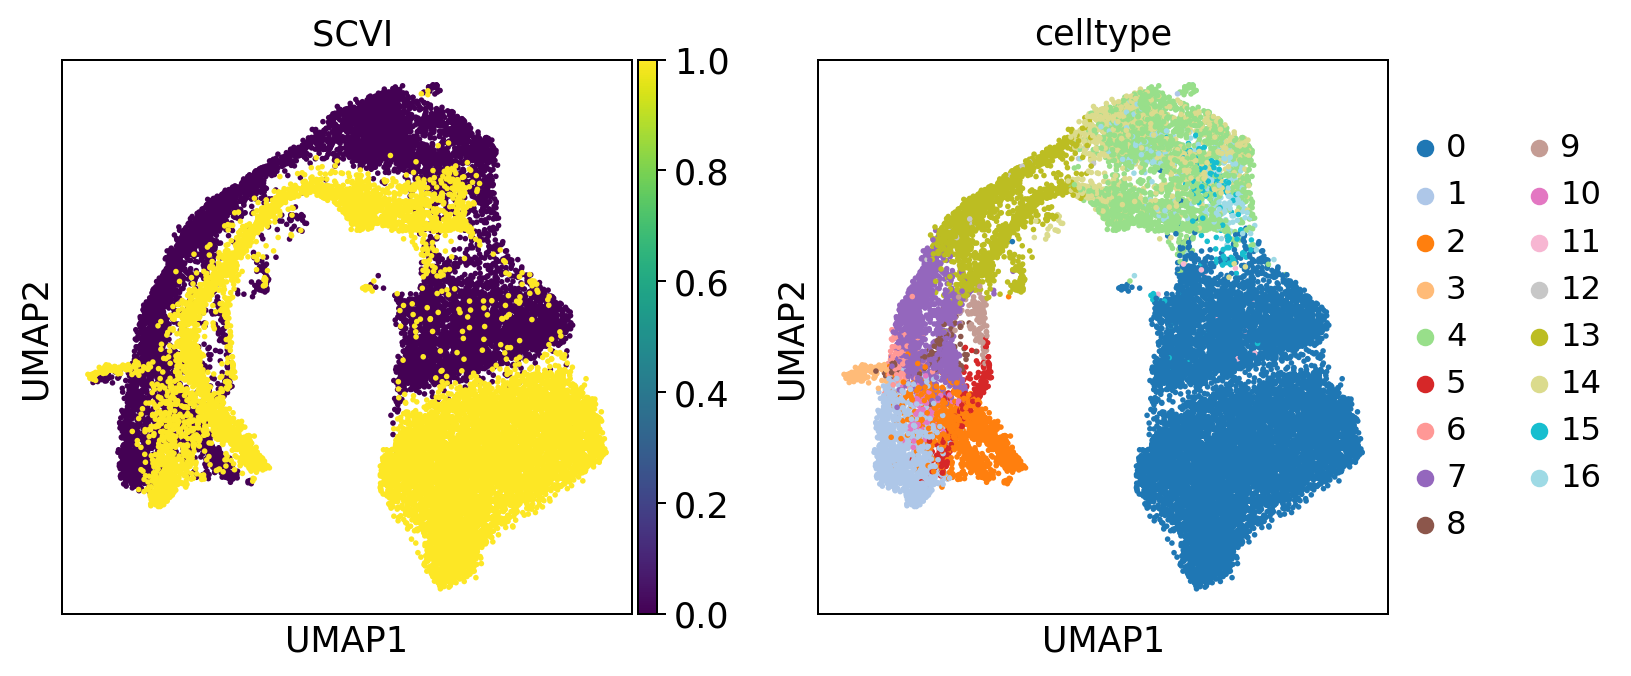

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


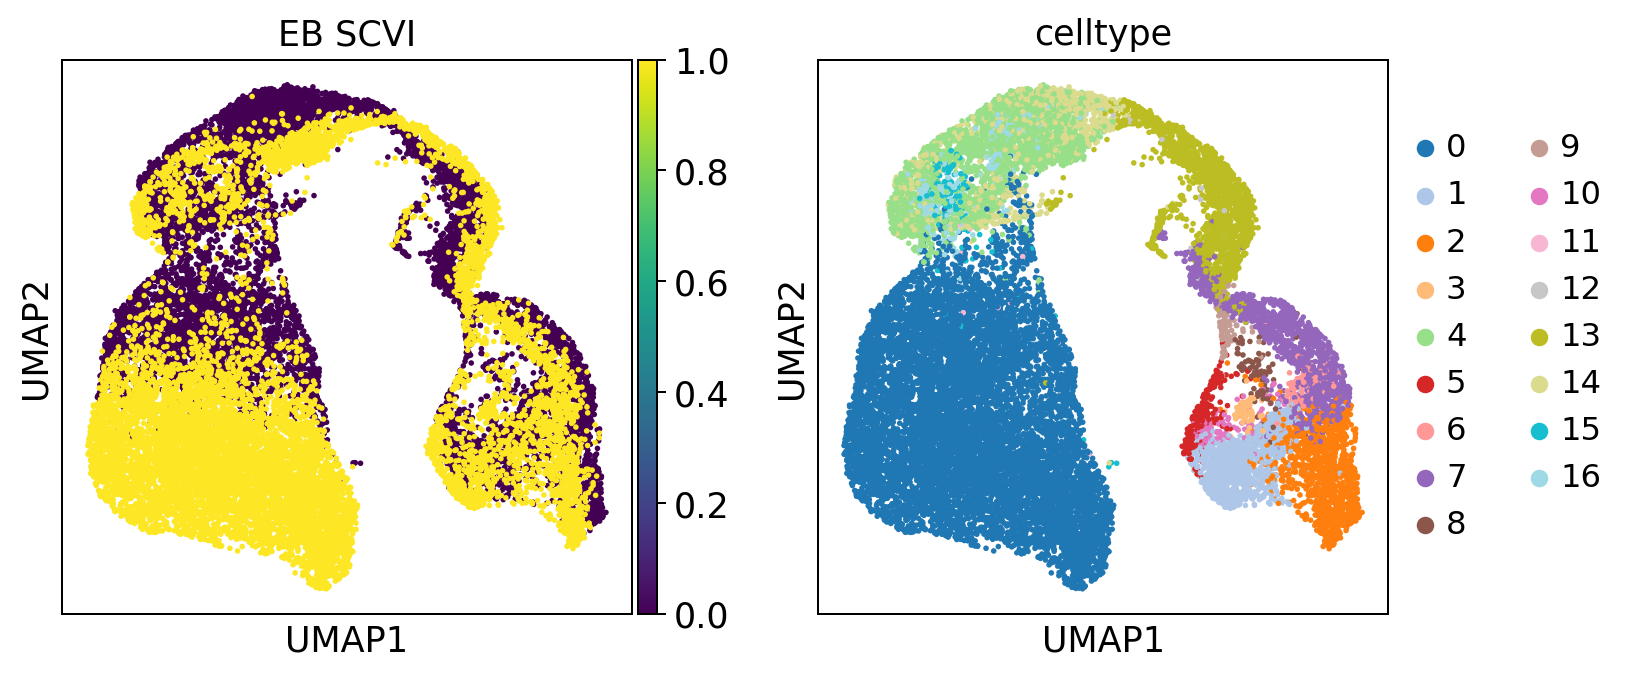

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


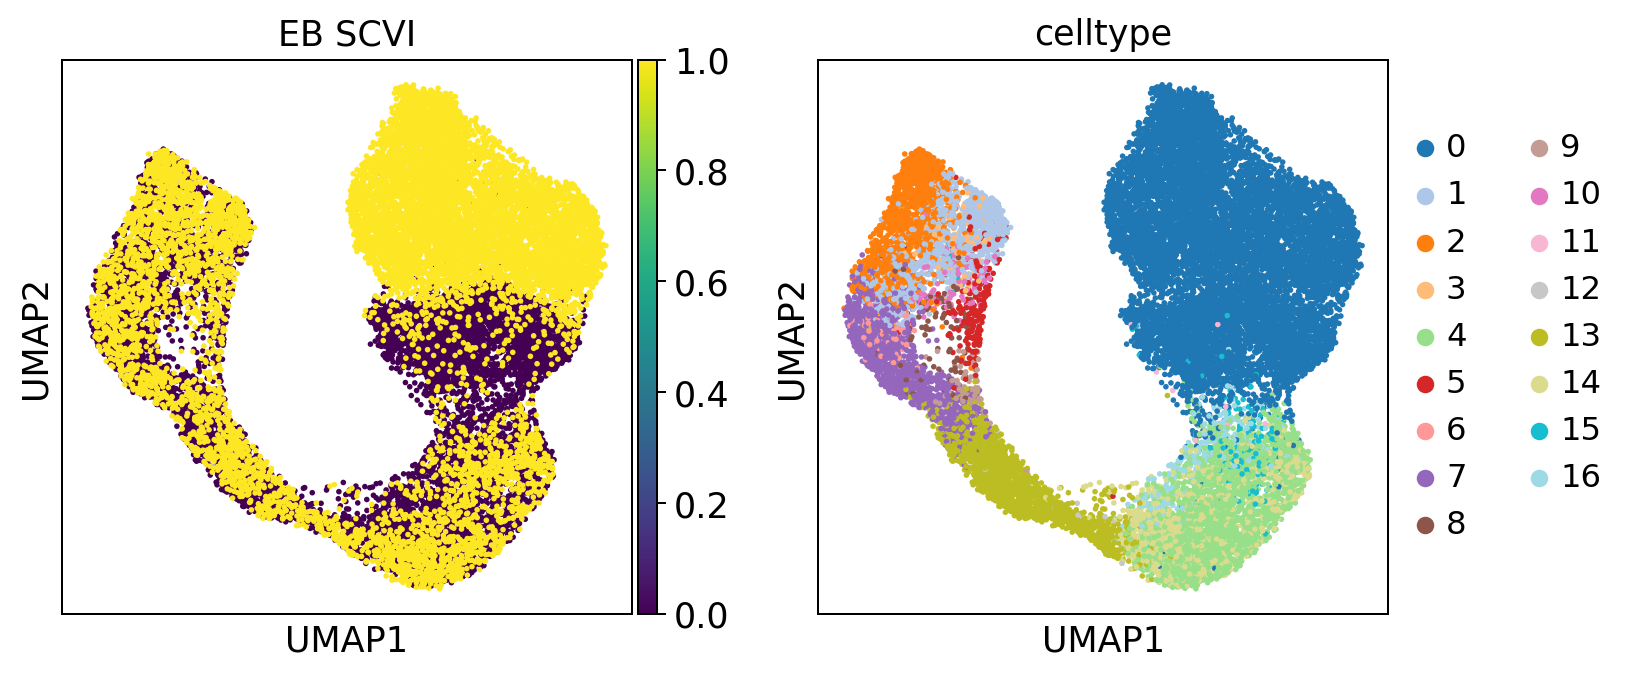

In [31]:
sc.pl.umap(adata_vae_z, color=["experimental_time", "celltype"], 
          palette="tab20",
          color_map="viridis", 
          frameon=True,
          add_outline=False, 
          size=20, 
         title=" SCVI")

sc.pl.umap(adata_geometric_z, color=["experimental_time", "celltype"], 
          palette="tab20",
          color_map="viridis", 
          frameon=True,
          add_outline=False, 
          size=20, 
         title="EB SCVI")

sc.pl.umap(adata_geodesic_z, color=["experimental_time", "celltype"], 
          palette="tab20",
          color_map="viridis", 
          frameon=True,
          add_outline=False, 
          size=20, 
          title="EB SCVI")

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


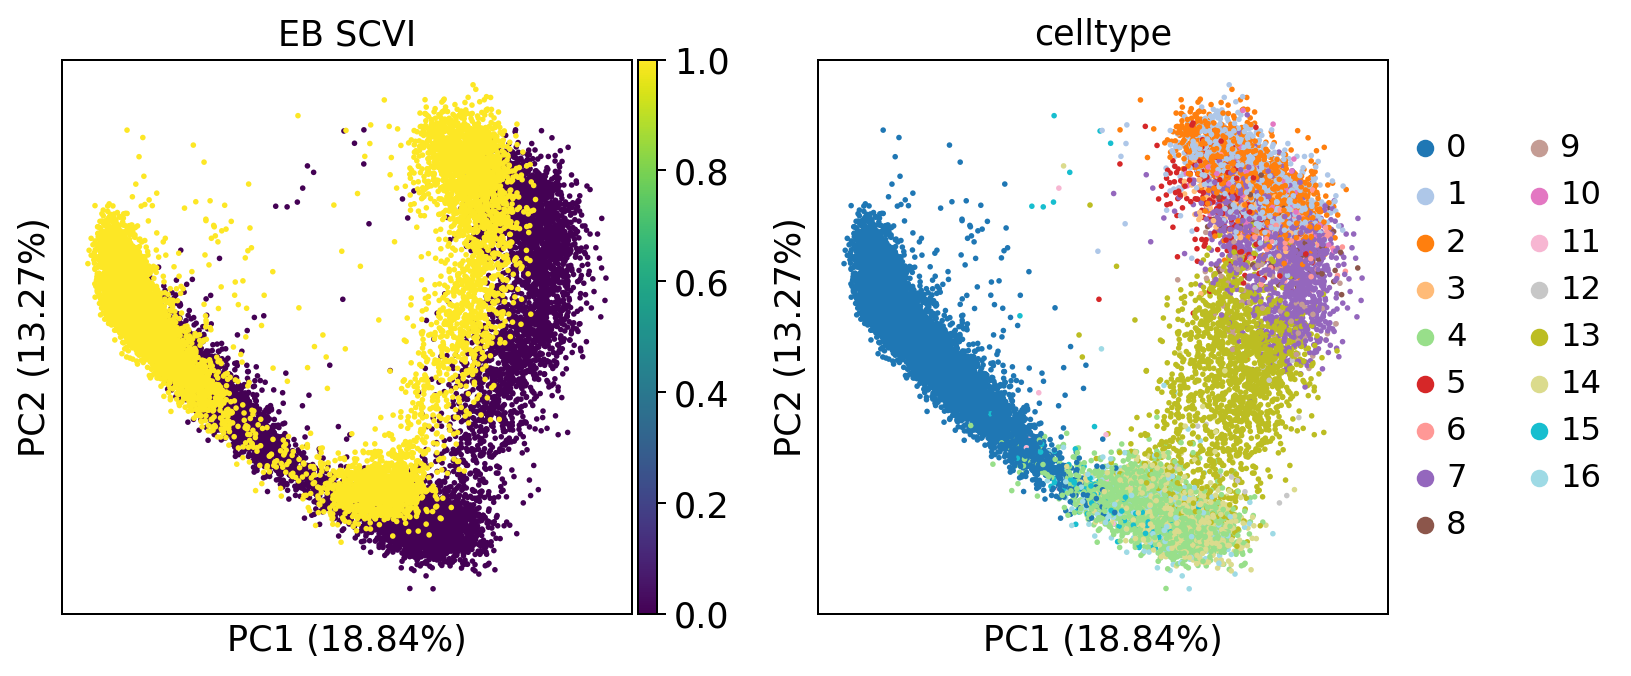

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


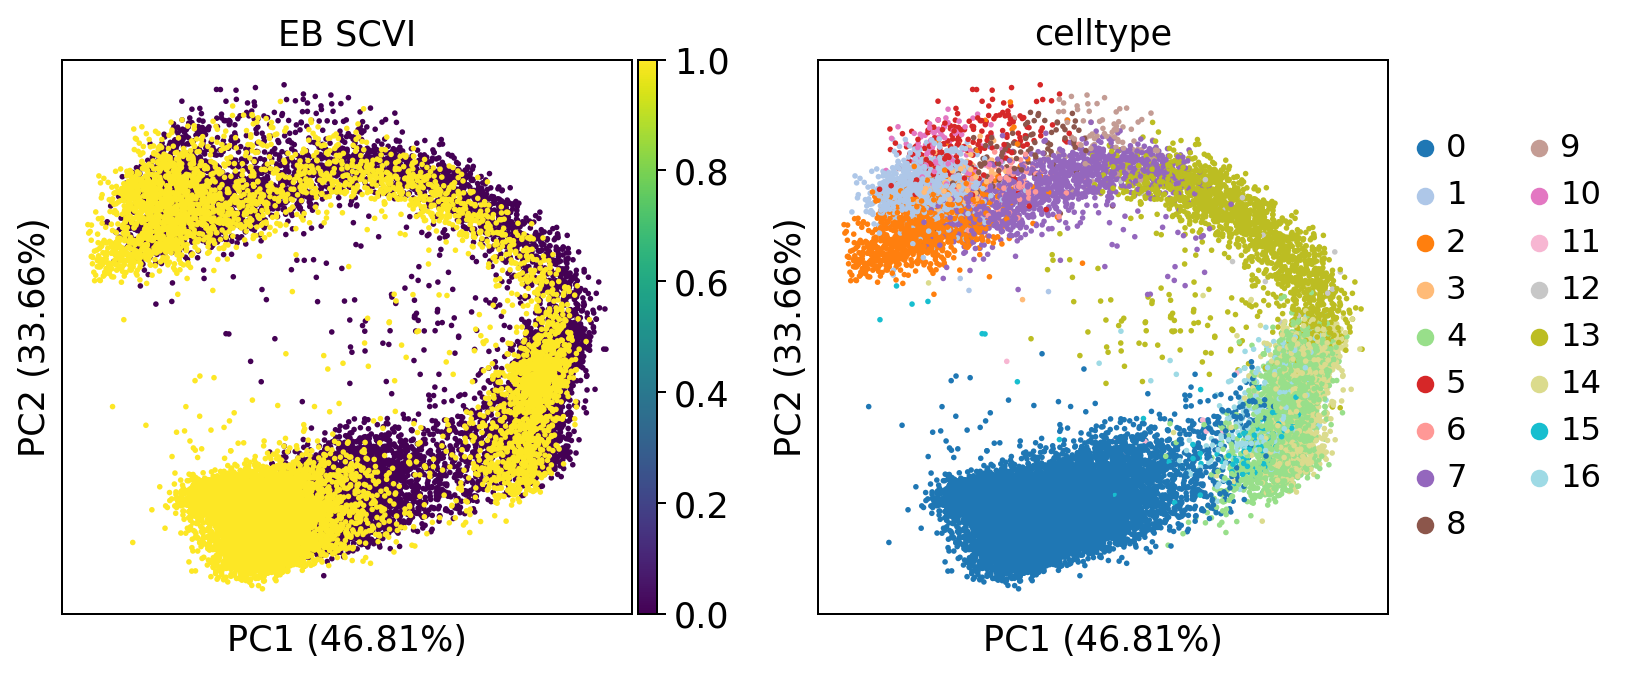

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


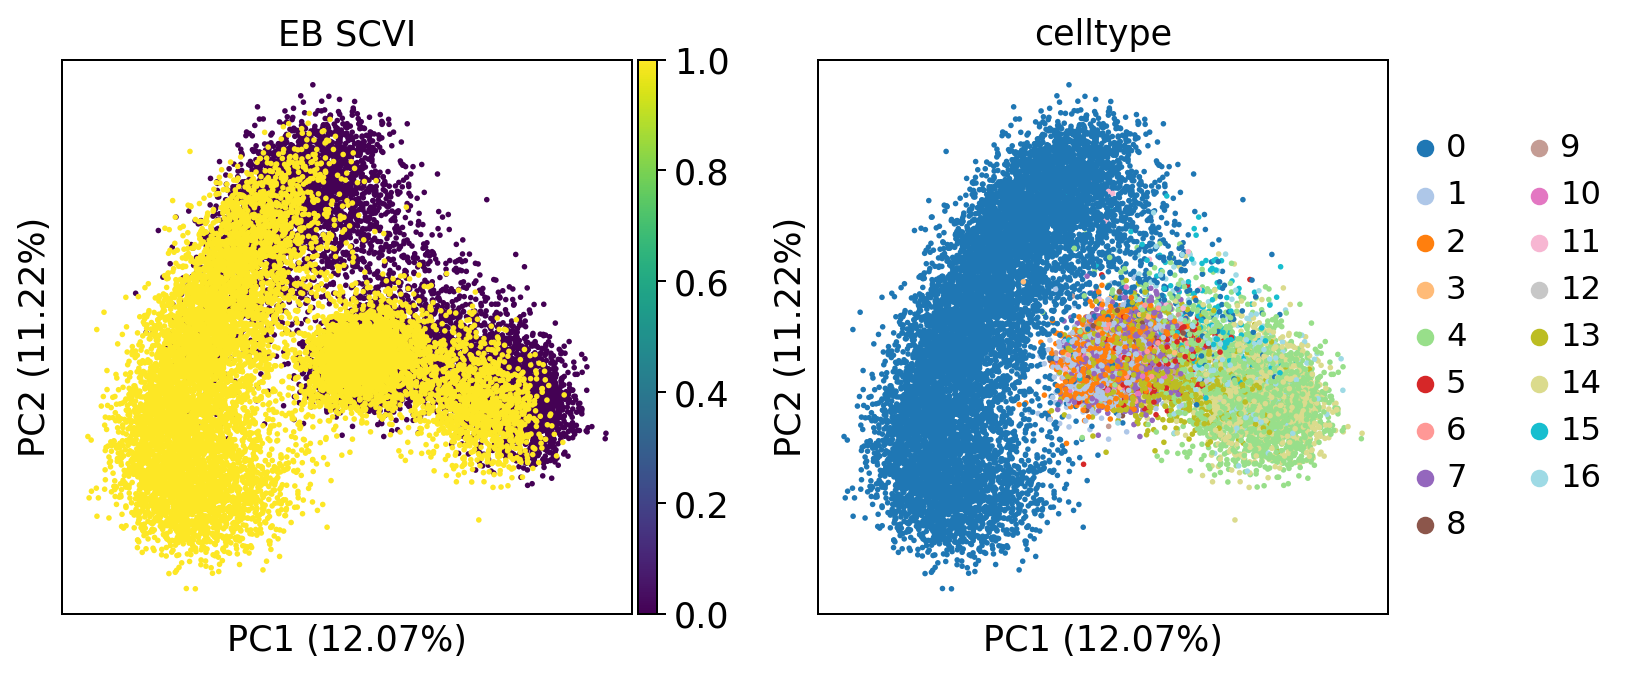

In [12]:
sc.set_figure_params(scanpy=True,
                         dpi=90, 
                         dpi_save=150,
                         frameon=True, 
                         vector_friendly=True,
                         fontsize=14, 
                         figsize=None,
                         color_map=None, 
                         format='pdf', 
                         facecolor=None, 
                         transparent=False, 
                         ipython_format='png2x')

sc.pl.pca(adata_vae_z, color=["experimental_time", "celltype"], 
          annotate_var_explained=True,
          color_map="viridis", 
          frameon=True,
          add_outline=False, 
          size=20, 
         title="EB SCVI")

sc.pl.pca(adata_geometric_z, color=["experimental_time", "celltype"], 
          annotate_var_explained=True,
          color_map="viridis", 
          frameon=True,
          add_outline=False, 
          size=20, 
         title="EB SCVI")

sc.pl.pca(adata_geodesic_z, color=["experimental_time", "celltype"], 
          annotate_var_explained=True,
          color_map="viridis", 
          frameon=True,
          add_outline=False, 
          size=20, 
         title="EB SCVI")

Plots for figures

In [13]:
geometric_state_type = []
vae_state_type = []
geodesic_state_type = []

for clus in adata_geometric_z.obs.celltype:
    if clus in terminal_states:
       geometric_state_type.append("terminal state") 
    elif clus in initial_states:
       geometric_state_type.append("initial state") 
    else:
       geometric_state_type.append("intermediate state") 

for clus in adata_vae_z.obs.celltype:
    if clus in terminal_states:
       vae_state_type.append("terminal state") 
    elif clus in initial_states:
       vae_state_type.append("initial state") 
    else:
       vae_state_type.append("intermediate state") 

for clus in adata_geodesic_z.obs.celltype:
    if clus in terminal_states:
       geodesic_state_type.append("terminal") 
    elif clus in initial_states:
       geodesic_state_type.append("initial") 
    else:
       geodesic_state_type.append("intermediate") 

adata_geometric_z.obs["state_type"] = geometric_state_type
adata_geodesic_z.obs["state_type"] = geodesic_state_type
adata_vae_z.obs["state_type"] = vae_state_type

adata_vae_z.uns['state_type_colors'] = ["firebrick", "gainsboro", "dodgerblue"]
adata_geometric_z.uns['state_type_colors'] = ["firebrick", "gainsboro", "dodgerblue"]
adata_geodesic_z.uns['state_type_colors'] = ["firebrick", "gainsboro", "dodgerblue"]

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


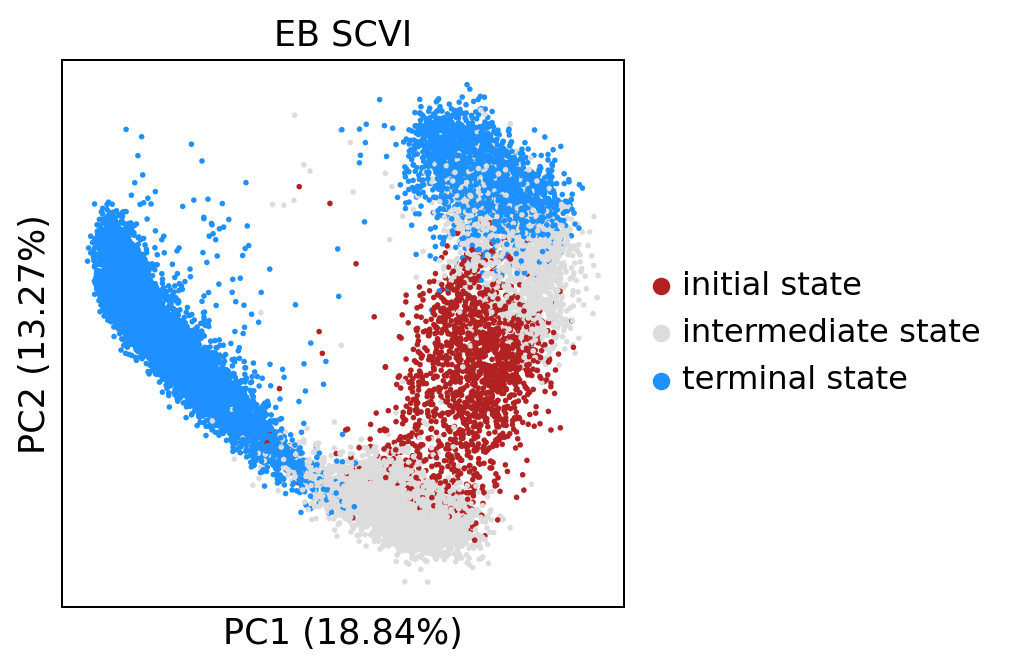

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


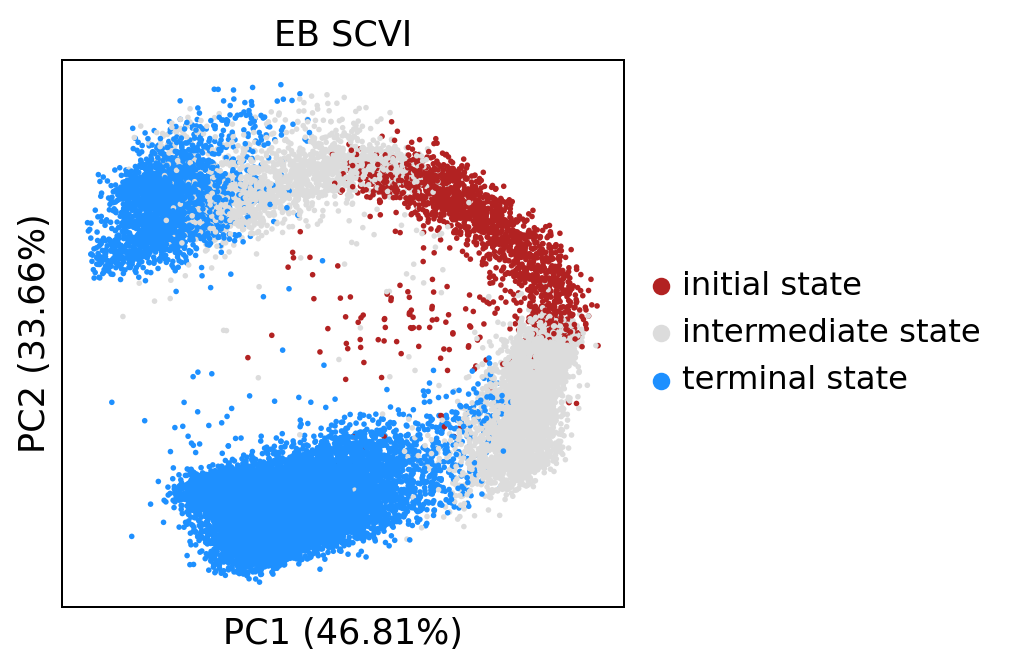

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


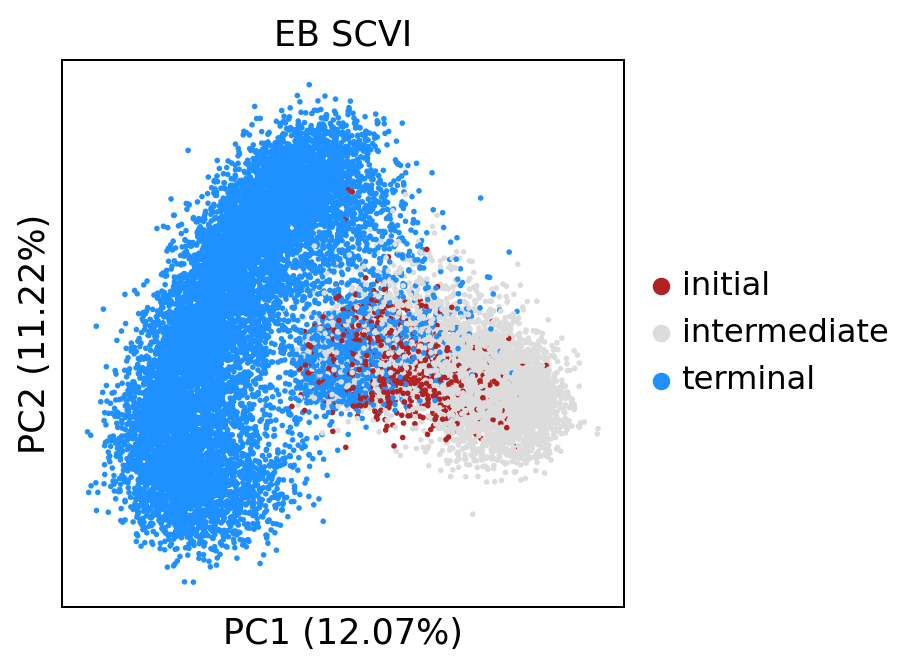

In [14]:
sc.set_figure_params(scanpy=True,
                         dpi=90, 
                         dpi_save=150,
                         frameon=False, 
                         vector_friendly=True,
                         fontsize=14, 
                         figsize=None,
                         color_map=None, 
                         format='pdf', 
                         facecolor=None, 
                         transparent=False, 
                         ipython_format='png2x')

sc.pl.pca(adata_vae_z, color="state_type", 
          annotate_var_explained=True,
          frameon=True,
          add_outline=False, 
          size=20, 
         title="EB SCVI")

sc.pl.pca(adata_geometric_z, color="state_type", 
          annotate_var_explained=True,
          frameon=True,
          add_outline=False, 
          size=20, 
         title="EB SCVI")

sc.pl.pca(adata_geodesic_z, color="state_type", 
          annotate_var_explained=True,
          frameon=True,
          add_outline=False, 
          size=20, 
         title="EB SCVI", 
         save='myfigure.svg')

## Save anndata

In [15]:
# adata_vae_z.layers["X_latents"] = adata_vae_z.X.copy()
# adata_vae_z.write_h5ad(PROJECT_FOLDER / "data/pancreas/flat/pancreas_lib_high_d.h5ad")

In [16]:
# adata_geometric_z.layers["X_latents"] = adata_geometric_z.X.copy()
# adata_geometric_z.write_h5ad(PROJECT_FOLDER / "data/pancreas/flat/pancreas_flat_lib_high_d.h5ad")

In [17]:
# adata_geodesic_z.layers["X_latents"] = adata_geodesic_z.X.copy()
# adata_geodesic_z.write_h5ad(PROJECT_FOLDER / "data/pancreas/flat/pancreas_geodesic_lib_high_d.h5ad")

**Compare latents**

In [18]:
annot = ["geometric" for _ in range(len(adata_geometric_z))] + ["vae" for _ in range(len(adata_vae_z))] + ["geodesic" for _ in range(len(adata_geodesic_z))]
concat = anndata.concat([adata_geometric_z, adata_vae_z, adata_geodesic_z], merge="same")
concat.obs["dataset_type"] = annot

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


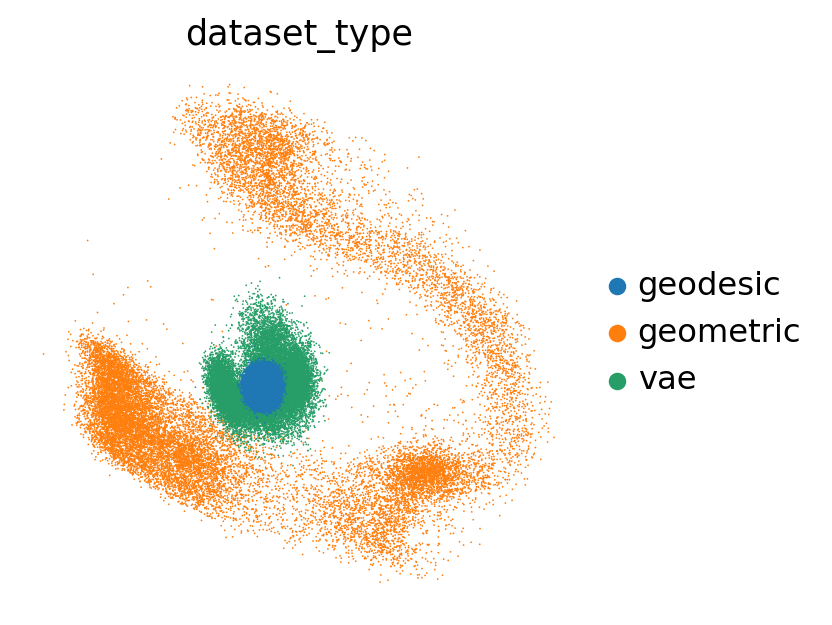

In [19]:
sc.tl.pca(concat)
sc.pl.pca(concat, color="dataset_type")

/home/icb/alessandro.palma/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


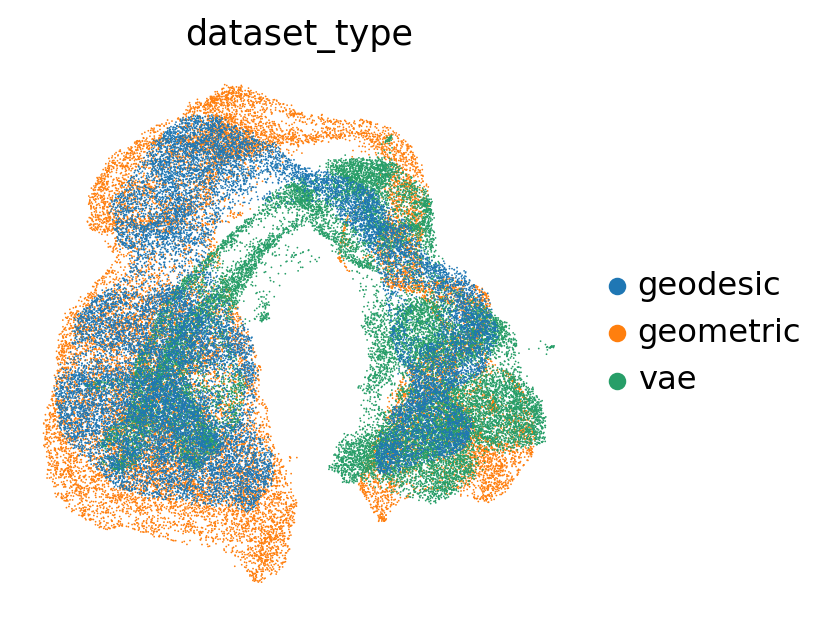

In [20]:
sc.pl.umap(concat, color="dataset_type")

**Latent sizes**

<Axes: xlabel='values', ylabel='Count'>

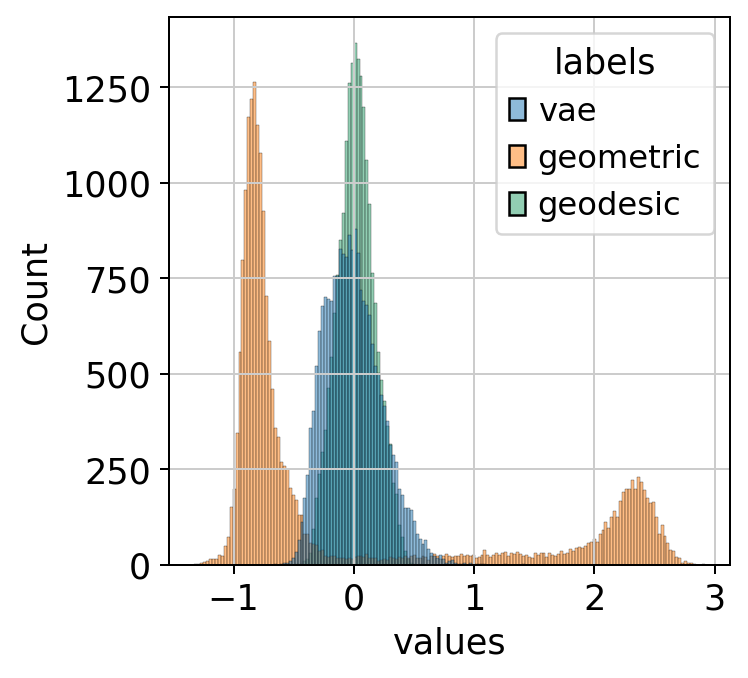

In [22]:
vae_mean_df = make_joint_df([adata_vae_z.X.mean(1), adata_geometric_z.X.mean(1), adata_geodesic_z.X.mean(1)], 
                              ["vae", "geometric", "geodesic"])
sns.histplot(vae_mean_df, x="values", hue="labels")

**Compare real and generated data**

In [23]:
adata_real = adata_vae_amortized_real[adata_vae_amortized_real.obs['dataset_type']=="real"]
adata_generated_vae = adata_vae_amortized_real[adata_vae_amortized_real.obs['dataset_type']=="generated_amortized"]
adata_generated_geometric = adata_geometric_amortized_real[adata_geometric_amortized_real.obs['dataset_type']=="generated_amortized"]
adata_generated_geodesic = adata_geodesic_amortized_real[adata_geodesic_amortized_real.obs['dataset_type']=="generated_amortized"]

adata_real.layers["X_norm"] = adata_real.X.copy()
adata_generated_vae.layers["X_norm"] = adata_generated_vae.X.copy()
adata_generated_geometric.layers["X_norm"] = adata_generated_geometric.X.copy()

sc.pp.log1p(adata_real)
sc.pp.log1p(adata_generated_geometric)
sc.pp.log1p(adata_generated_vae)

<Axes: xlabel='values', ylabel='Count'>

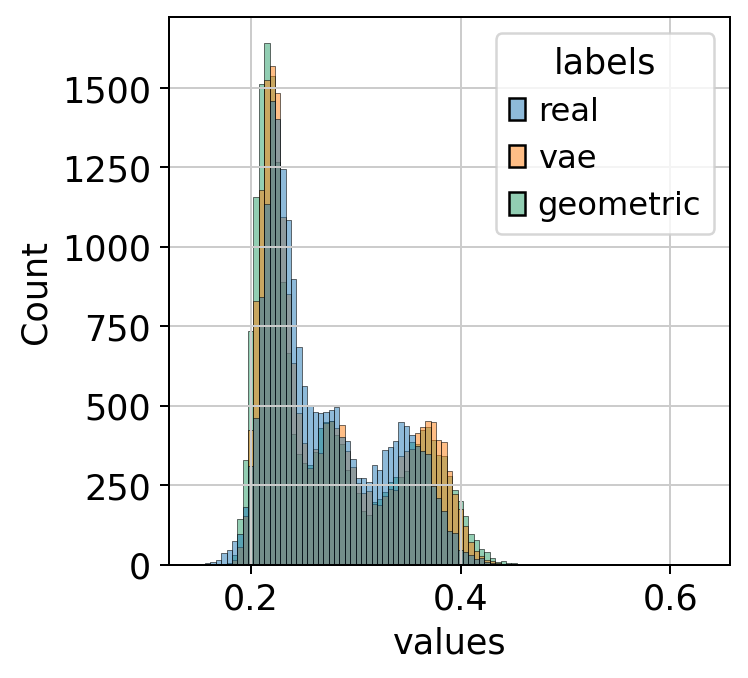

In [24]:
vae_mean_df = make_joint_df([adata_real.X.mean(1), 
                             adata_generated_vae.X.mean(1), 
                             adata_generated_geometric.X.mean(1)], 
                              ["real", "vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

<Axes: xlabel='values', ylabel='Count'>

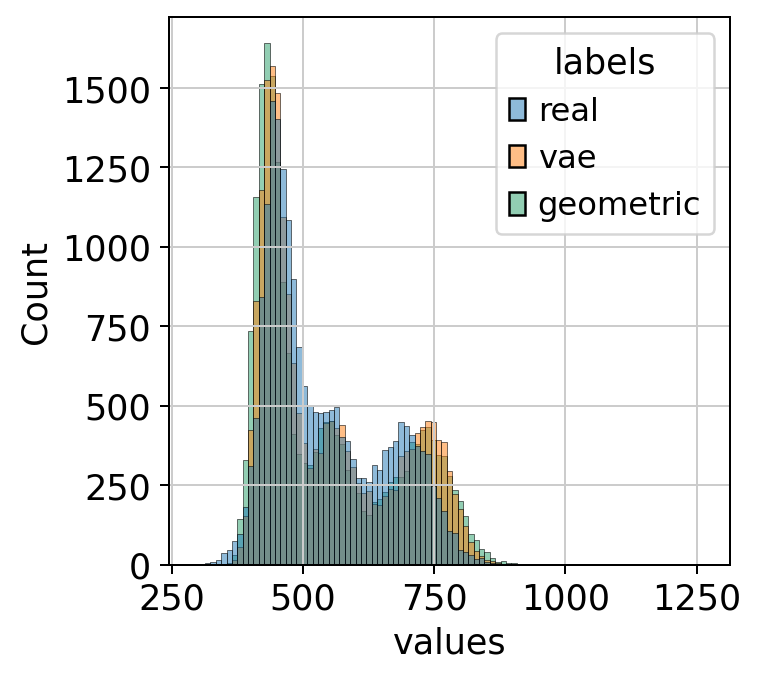

In [25]:
vae_mean_df = make_joint_df([adata_real.X.sum(1), 
                             adata_generated_vae.X.sum(1), 
                             adata_generated_geometric.X.sum(1)], 
                              ["real", "vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

<Axes: xlabel='values', ylabel='Count'>

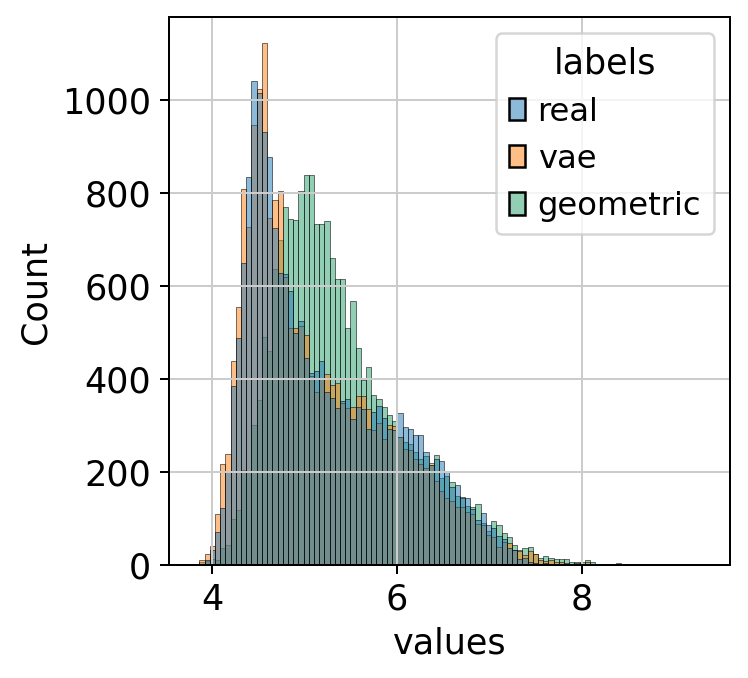

In [26]:
vae_mean_df = make_joint_df([adata_real.X.max(1), 
                             adata_generated_vae.X.max(1), 
                             adata_generated_geometric.X.max(1)], 
                              ["real", "vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

<Axes: xlabel='values', ylabel='Count'>

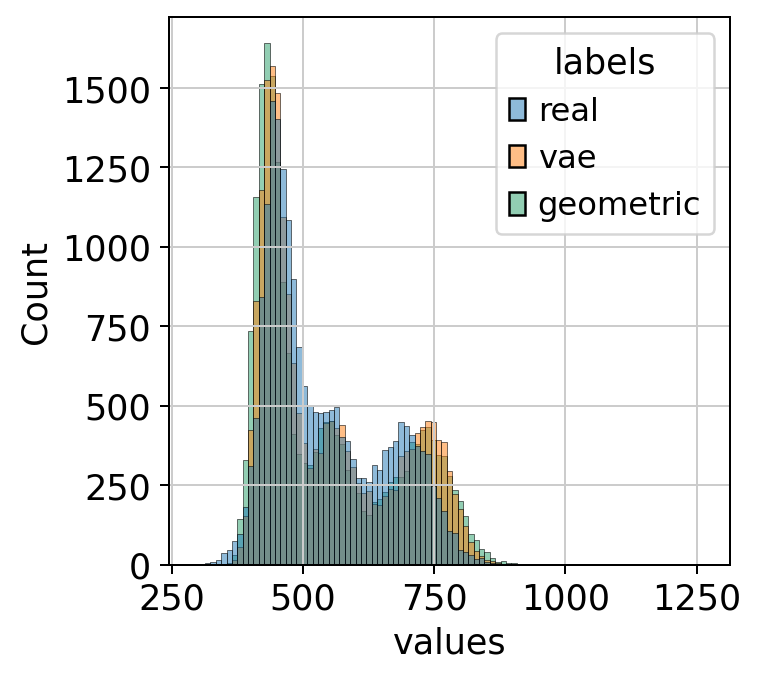

In [27]:
vae_mean_df = make_joint_df([adata_real.X.sum(1), 
                             adata_generated_vae.X.sum(1), 
                             adata_generated_geometric.X.sum(1)], 
                              ["real", "vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

<Axes: xlabel='values', ylabel='Count'>

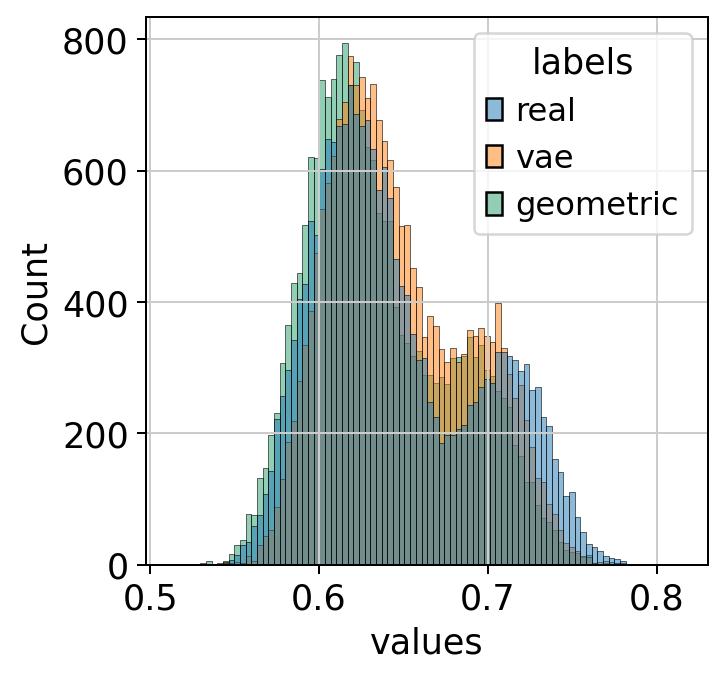

In [28]:
vae_mean_df = make_joint_df([adata_real.X.std(1), 
                             adata_generated_vae.X.std(1), 
                             adata_generated_geometric.X.std(1)], 
                              ["real", "vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

<Axes: xlabel='values', ylabel='Count'>

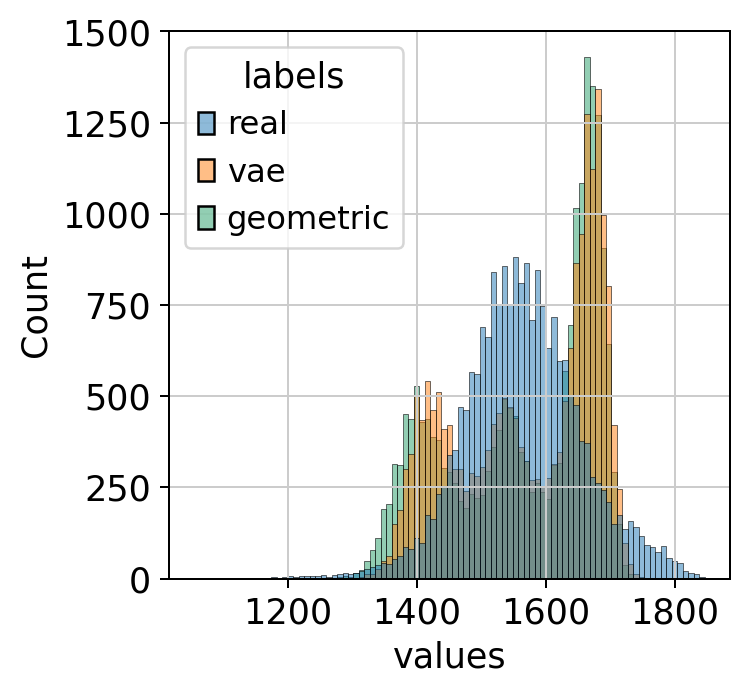

In [29]:
vae_mean_df = make_joint_df([(adata_real.X==0).sum(1), 
                             (adata_generated_vae.X==0).sum(1), 
                             (adata_generated_geometric.X==0).sum(1)], 
                              ["real", "vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

<Axes: xlabel='values', ylabel='Count'>

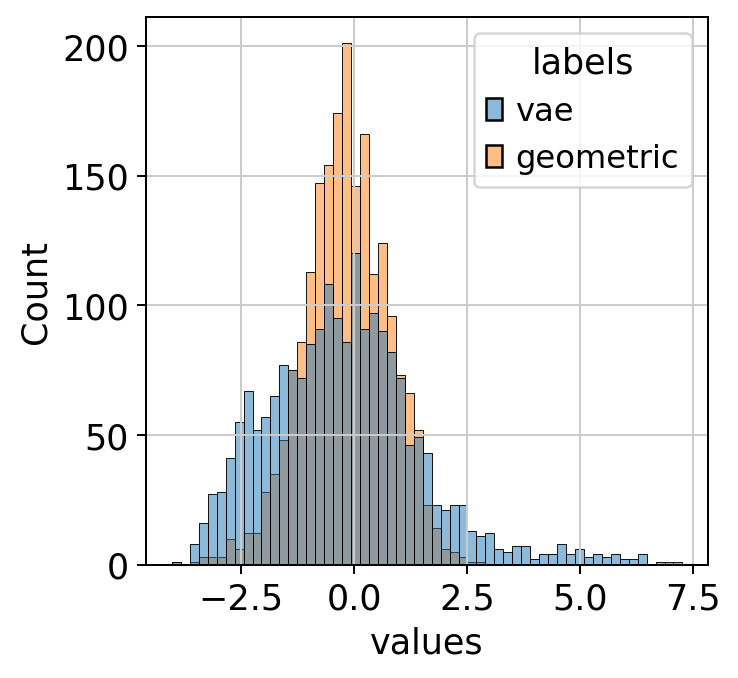

In [30]:
vae_mean_df = make_joint_df([vae.theta.detach().cpu().numpy(), 
                             geometric_vae.theta.detach().cpu().numpy()], 
                              ["vae", "geometric"])
sns.histplot(vae_mean_df, x="values", hue="labels")

## Compare sparsity

<Axes: xlabel='values', ylabel='Count'>

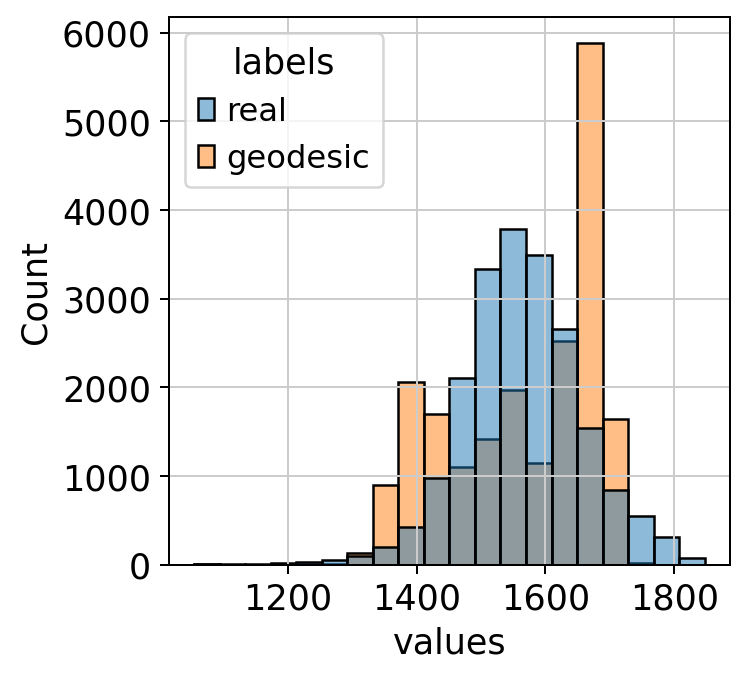

In [31]:
vae_zeros_df = make_joint_df([(adata_real.X==0).sum(1), 
                             (adata_generated_geometric.X==0).sum(1)], 
                              ["real", "geodesic"])

sns.histplot(vae_zeros_df, x="values", hue="labels", bins=20)

/tmp/ipykernel_3871833/1011032873.py:1: ImplicitModificationWarning: Trying to modify attribute `.X` of view, initializing view as actual.
  adata_generated_geodesic.X[adata_generated_geodesic.X<1e-2] = 0


<Axes: xlabel='values', ylabel='Count'>

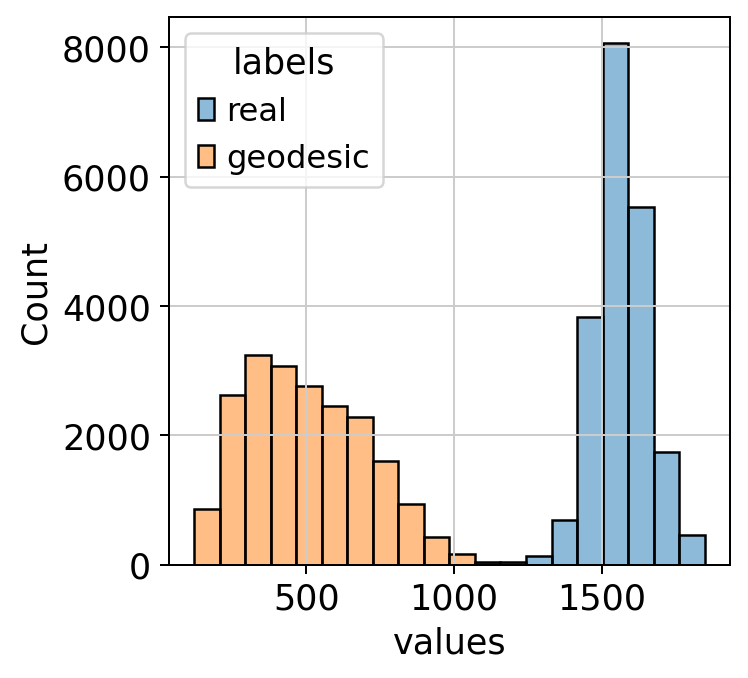

In [32]:
adata_generated_geodesic.X[adata_generated_geodesic.X<1e-2] = 0
vae_zeros_df = make_joint_df([(adata_real.X==0).sum(1), 
                             (adata_generated_geodesic.X==0).sum(1)], 
                              ["real", "geodesic"])

sns.histplot(vae_zeros_df, x="values", hue="labels", bins=20)

### Combined sparsity df

Text(0, 0.5, 'Frequency')

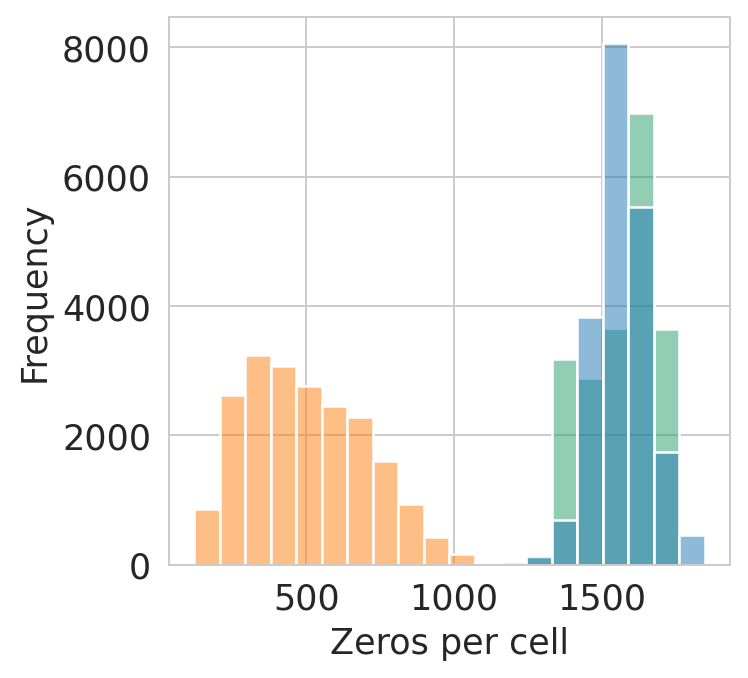

In [60]:
adata_generated_geodesic.X[adata_generated_geodesic.X<1e-2] = 0
vae_zeros_df = make_joint_df([(adata_real.X==0).sum(1), 
                             (adata_generated_geodesic.X==0).sum(1), 
                             (adata_generated_geometric.X==0).sum(1)], 
                              ["Real", "Geodesic", "FlatVI"])

sns.histplot(vae_zeros_df, x="values", hue="labels", bins=20, legend=False)
plt.xlabel("Zeros per cell")
plt.ylabel("Frequency")

## Plot the mean variance trend

In [34]:
mean_real = adata_real.X.mean(0)
variance_real = adata_real.X.std(0)

mean_vae = adata_generated_vae.X.mean(0)
variance_vae = adata_generated_vae.X.std(0)

mean_geometric = adata_generated_geometric.X.mean(0)
variance_geometric = adata_generated_geometric.X.std(0)

<Figure size 360x360 with 0 Axes>

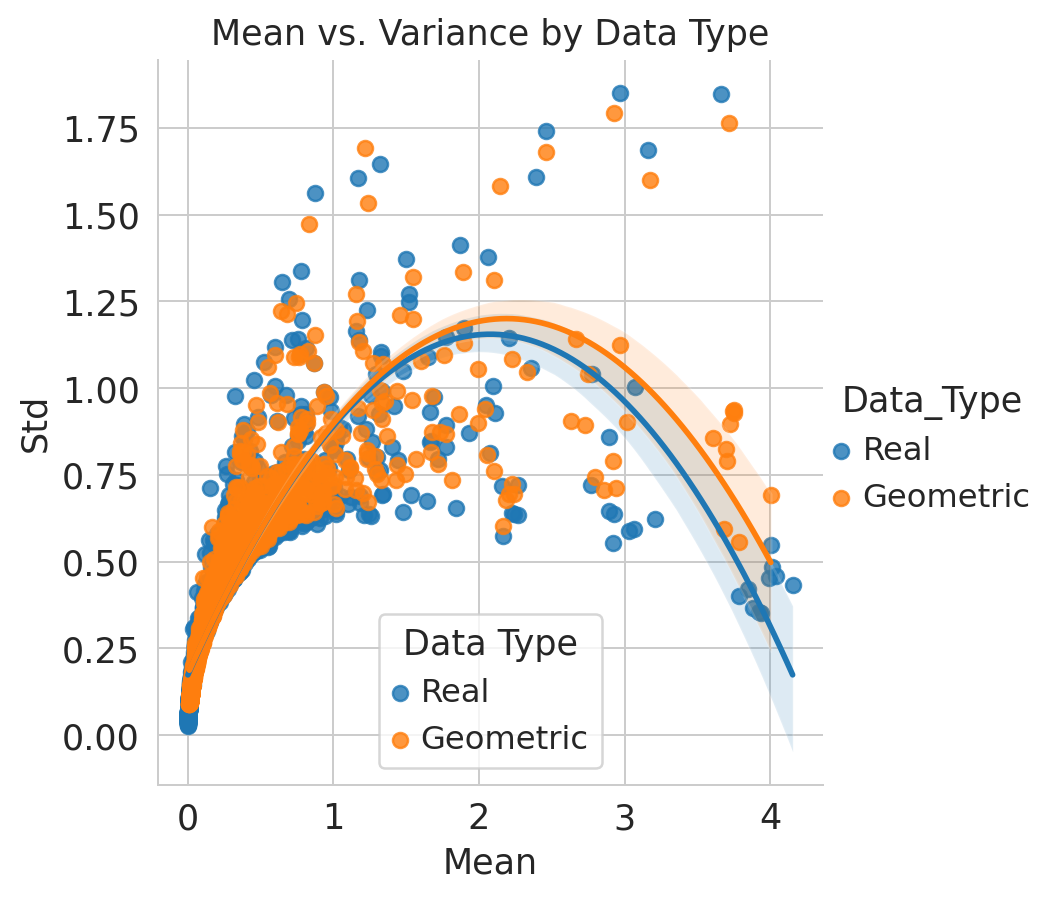

In [35]:
# Create a DataFrame with the data
# data = pd.DataFrame({
#     'Mean': np.concatenate([mean_real, mean_vae, mean_geometric]),
#     'Variance': np.concatenate([variance_real, variance_vae, variance_geometric]),
#     'Data_Type': ['Real'] * len(mean_real) + ['VAE'] * len(mean_vae) + ['Geometric'] * len(mean_geometric)
# })

data = pd.DataFrame({
    'Mean': np.concatenate([mean_real, mean_geometric]),
    'Variance': np.concatenate([variance_real, variance_geometric]),
    'Data_Type': ['Real'] * len(mean_real) + ['Geometric'] * len(mean_geometric)
})

# Create a Seaborn regression plot
plt.figure(figsize=(4, 4))
sns.set_style("whitegrid")
# sns.lmplot(data=data, x='Mean', y='Variance', hue='Data_Type',scatter_kws={'s': 50, 'alpha': 0.7})
sns.lmplot(data=data, x='Mean', y='Variance', hue='Data_Type', order=2)

# Customize the plot
plt.xlabel('Mean')
plt.ylabel('Std')
plt.title('Mean vs. Variance by Data Type')

# Show the legend
plt.legend(title='Data Type')

# Show the plot
plt.show()

## Plot mean-variance trend geodesic

In [36]:
mean_geodesic = adata_generated_geodesic.X.mean(0)
variance_geodesic = adata_generated_geodesic.X.var(0)

<Figure size 360x360 with 0 Axes>

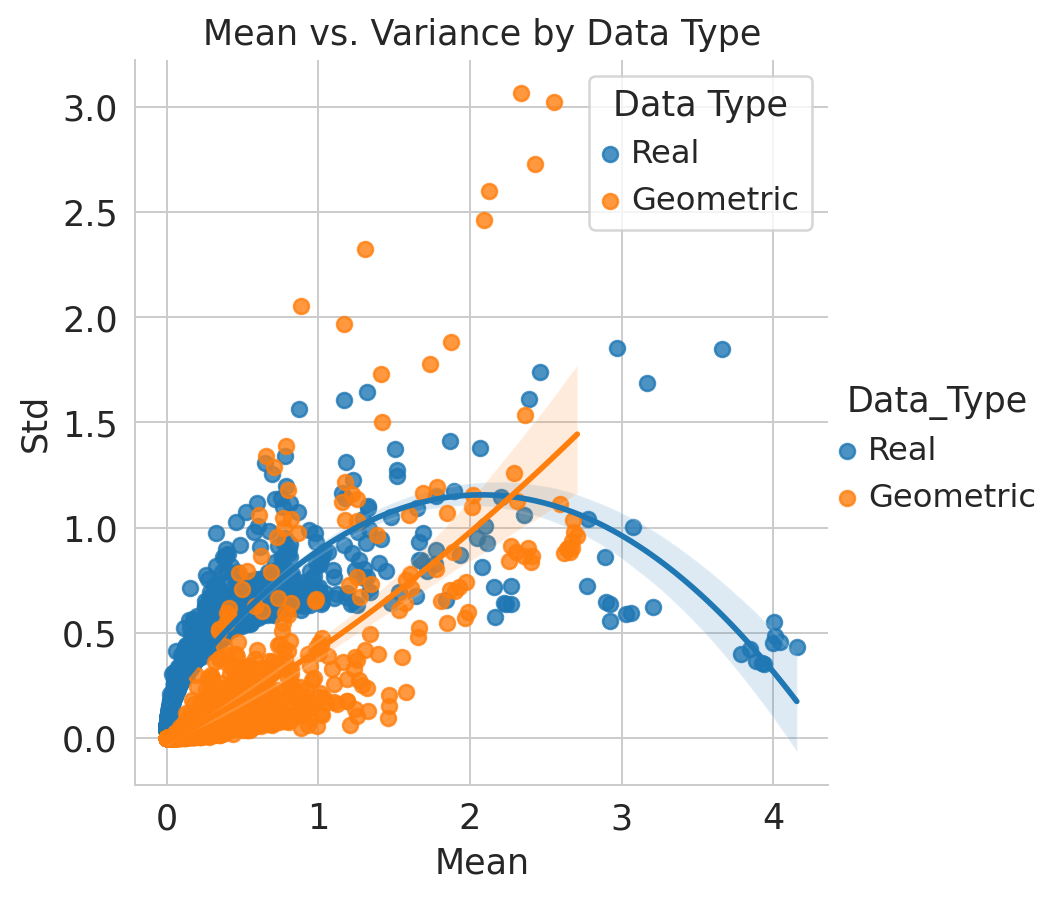

In [37]:
data = pd.DataFrame({
    'Mean': np.concatenate([mean_real, mean_geodesic]),
    'Variance': np.concatenate([variance_real, variance_geodesic]),
    'Data_Type': ['Real'] * len(mean_real) + ['Geometric'] * len(mean_geodesic)
})

# Create a Seaborn regression plot
plt.figure(figsize=(4, 4))
sns.set_style("whitegrid")
# sns.lmplot(data=data, x='Mean', y='Variance', hue='Data_Type',scatter_kws={'s': 50, 'alpha': 0.7})
sns.lmplot(data=data, x='Mean', y='Variance', hue='Data_Type', order=2)

# Customize the plot
plt.xlabel('Mean')
plt.ylabel('Std')
plt.title('Mean vs. Variance by Data Type')

# Show the legend
plt.legend(title='Data Type')

# Show the plot
plt.show()

## Plot mean-variance trend together

<Figure size 360x270 with 0 Axes>

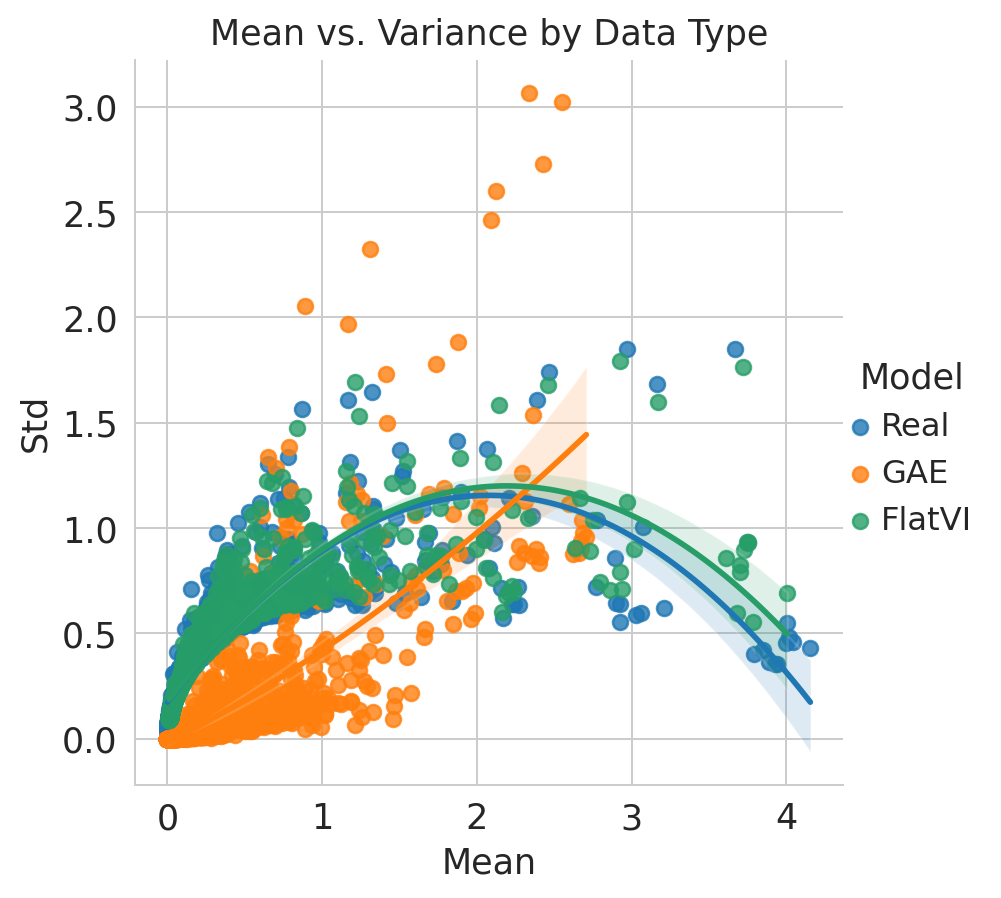

In [58]:
# Create a DataFrame with the data
data = pd.DataFrame({
    'Mean': np.concatenate([mean_real, mean_geodesic, mean_geometric]),
    'Variance': np.concatenate([variance_real, variance_geodesic, variance_geometric]),
    'Model': ['Real'] * len(mean_real) + ['GAE'] * len(variance_geodesic) + ['FlatVI'] * len(mean_geometric)
})


# Create a Seaborn regression plot
plt.figure(figsize=(4, 3))
sns.set_style("whitegrid")
# sns.lmplot(data=data, x='Mean', y='Variance', hue='Data_Type',scatter_kws={'s': 50, 'alpha': 0.7})
sns.lmplot(data=data, x='Mean', y='Variance', hue='Model', order=2)

# Customize the plot
plt.xlabel('Mean')
plt.ylabel('Std')
plt.title('Mean vs. Variance by Data Type')

# Show the legend
# plt.legend(title='Data Type')

# Show the plot
plt.show()

## Quantify clustering apart

In [39]:
from sklearn import metrics

In [40]:
adata_vae_z_term = adata_vae_z[adata_vae_z.obs.state_type.isin(["terminal state", "initial state"])]
adata_geometric_z_term = adata_geometric_z[adata_geometric_z.obs.state_type.isin(["terminal state", "initial state"])]
adata_geodesic_z_term = adata_geodesic_z[adata_geodesic_z.obs.state_type.isin(["terminal", "initial"])]

**Silhouette score**

In [41]:
metrics.silhouette_score(adata_vae_z_term.obsm["X_pca"], adata_vae_z_term.obs["state_type"], metric='euclidean')

0.26038253

In [42]:
metrics.silhouette_score(adata_geometric_z_term.obsm["X_pca"], adata_geometric_z_term.obs["state_type"], metric='euclidean')

0.5010895

In [43]:
metrics.silhouette_score(adata_geodesic_z_term.obsm["X_pca"], adata_geodesic_z_term.obs["state_type"], metric='euclidean')

0.14923766

**Calinski-Harabasz Index**

In [44]:
metrics.calinski_harabasz_score(adata_vae_z_term.obsm["X_pca"], adata_vae_z_term.obs["state_type"])

2191.47532972229

In [45]:
metrics.calinski_harabasz_score(adata_geometric_z_term.obsm["X_pca"], adata_geometric_z_term.obs["state_type"])

6986.313881073738

In [46]:
metrics.calinski_harabasz_score(adata_geodesic_z_term.obsm["X_pca"], adata_geodesic_z_term.obs["state_type"])

1723.1342132396303

**Davies-Bouldin Index**

In [47]:
metrics.davies_bouldin_score(adata_vae_z_term.obsm["X_pca"], adata_vae_z_term.obs["state_type"])

1.562726089333253

In [48]:
metrics.davies_bouldin_score(adata_geometric_z_term.obsm["X_pca"], adata_geometric_z_term.obs["state_type"])

0.7317009250744955

In [49]:
metrics.davies_bouldin_score(adata_geodesic_z_term.obsm["X_pca"], adata_geodesic_z_term.obs["state_type"])

1.5003842323690282

## PertPy distance metrics

In [50]:
# import pertpy as pt
# from sklearn.preprocessing import StandardScaler, MinMaxScaler


KeyboardInterrupt



In [ ]:
# def standardize_layer_adata(adata, layer):
#     scaler = MinMaxScaler()
    
#     # Fit the scaler to your data
#     scaler.fit(adata.obsm[layer])
    
#     # Transform the data matrix using the scaler
#     adata.obsm[layer] = scaler.transform(adata.obsm[layer])
#     return adata

In [51]:
# adata_vae_z_term_norm = standardize_layer_adata(adata_vae_z_term.copy(), "X_pca")
# adata_geometric_z_term_norm = standardize_layer_adata(adata_geometric_z_term.copy(),  "X_pca")
# adata_geodesic_z_term_norm = standardize_layer_adata(adata_geodesic_z_term.copy(),  "X_pca")

**Wasserstein**

In [52]:
# distance = pt.tl.Distance("wasserstein", obsm_key="X_pca")
# vae_w_dist = distance.pairwise(adata_vae_z_term_norm, groupby="state_type").to_numpy().max()
# distance = pt.tl.Distance("wasserstein", obsm_key="X_pca")
# geometric_w_dist = distance.pairwise(adata_geometric_z_term_norm, groupby="state_type").to_numpy().max()
# distance = pt.tl.Distance("wasserstein", obsm_key="X_pca")
# geodesic_w_dist = distance.pairwise(adata_geodesic_z_term_norm, groupby="state_type").to_numpy().max()

In [ ]:
vae_w_dist

In [ ]:
geometric_w_dist

In [ ]:
geodesic_w_dist

**Mean Pairwise Distance**

In [ ]:
distance = pt.tl.Distance("mean_pairwise", obsm_key="X_pca")
vae_mp_dist = distance.pairwise(adata_vae_z_term_norm, groupby="state_type").to_numpy().max()
distance = pt.tl.Distance("mean_pairwise", obsm_key="X_pca")
geometric_mp_dist = distance.pairwise(adata_geometric_z_term_norm, groupby="state_type").to_numpy().max()
distance = pt.tl.Distance("mean_pairwise", obsm_key="X_pca")
geodesic_mp_dist = distance.pairwise(adata_geodesic_z_term_norm, groupby="state_type").to_numpy().max()

In [ ]:
vae_mp_dist

In [ ]:
geometric_mp_dist

In [ ]:
geodesic_mp_dist

**MMD**

In [ ]:
distance = pt.tl.Distance("mmd", obsm_key="X_pca")
vae_mmd_dist = distance.pairwise(adata_vae_z_term_norm, groupby="state_type").to_numpy().max()
distance = pt.tl.Distance("mmd", obsm_key="X_pca")
geometric_mmd_dist = distance.pairwise(adata_geometric_z_term_norm, groupby="state_type").to_numpy().max()
distance = pt.tl.Distance("mmd", obsm_key="X_pca")
geodesic_mmd_dist = distance.pairwise(adata_geodesic_z_term_norm, groupby="state_type").to_numpy().max()

In [ ]:
vae_mmd_dist

In [ ]:
geometric_mmd_dist

In [ ]:
geodesic_mmd_dist